In [11]:
from __future__ import print_function
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import random
from sklearn import preprocessing


# data_root = "C:\\Users\\Tigran PC\\Desktop\\MicrobiomicsData\\data\\" # notebook
# data_root = "/Users/tigran/Desktop/sbv/data/" # imac
data_root = "C:\\Users\\Administrator\\" # istc pc

sub_data_root = data_root + "sample01split/"

In [12]:
def reformat_lables(labels):
    num_labels = len(np.unique(labels))
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

First reload the data we generated in Feature_Engineering.ipynb.

In [13]:
pickle_file = data_root + "DNA_data.pickle"

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    all_dataset = save.astype(np.float32)
    del save  # hint to help gc free up memory
    print('Training set', all_dataset.shape)


Training set (54997, 4097)


In [14]:
X = all_dataset.values[:, :-1]
X = preprocessing.scale(X)
y = all_dataset.values[:, -1]

train_dataset, all_test_dataset, train_labels, all_test_labels = train_test_split(X, y, test_size=0.2)

valid_dataset, test_dataset, valid_labels, test_labels =  train_test_split(all_test_dataset, all_test_labels, test_size=0.5)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Training set (43997, 4096) (43997,)
Validation set (5500, 4096) (5500,)
Test set (5500, 4096) (5500,)


In [15]:
train_labels = reformat_lables(train_labels)
valid_labels = reformat_lables(valid_labels)
test_labels = reformat_lables(test_labels)

In [16]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (43997, 4096) (43997, 2)
Validation set (5500, 4096) (5500, 2)
Test set (5500, 4096) (5500, 2)


## Multinomial logistic regression using stochastic gradient descent

In [17]:
batch_size = 32

features_size = train_dataset.shape[1]
num_labels = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, features_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([features_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [18]:
num_steps = 3001

predictions = None

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print(test_prediction.eval().shape)
    predictions = test_prediction.eval()
    

Initialized
Minibatch loss at step 0: 29.339027
Minibatch accuracy: 56.2%
Validation accuracy: 53.7%
Minibatch loss at step 500: 7.886947
Minibatch accuracy: 90.6%
Validation accuracy: 86.9%
Minibatch loss at step 1000: 7.281765
Minibatch accuracy: 87.5%
Validation accuracy: 88.1%
Minibatch loss at step 1500: 13.153898
Minibatch accuracy: 93.8%
Validation accuracy: 87.9%
Minibatch loss at step 2000: 4.650497
Minibatch accuracy: 90.6%
Validation accuracy: 87.5%
Minibatch loss at step 2500: 4.469972
Minibatch accuracy: 93.8%
Validation accuracy: 88.7%
Minibatch loss at step 3000: 13.210006
Minibatch accuracy: 78.1%
Validation accuracy: 88.2%
Test accuracy: 88.4%
(5500, 2)


In [19]:
pred = np.argmax(predictions, 1) 
label = np.dot(test_labels, range(num_labels))
print(accuracy_score(pred, label))
confusion_matrix(pred, label)

0.8843636363636364


array([[2787,  321],
       [ 315, 2077]], dtype=int64)

Normalized confusion matrix
[[0.89845261 0.10154739]
 [0.13386155 0.86613845]]


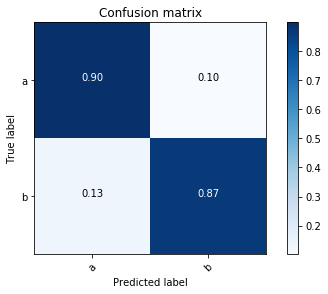

In [20]:
plot_confusion_matrix(confusion_matrix(label, pred), ['a','b'], normalize=True)

## 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. using stochastic gradient descent

In [21]:
batch_size = 32

features_size = train_dataset.shape[1]
num_labels = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, features_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    hidden_layer_size = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([features_size, hidden_layer_size]))
    hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]))
    
    hidden_logits = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(hidden_logits, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden_valid_weights = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid_weights, weights) + biases)
    hidden_test_weights = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test_weights, weights) + biases)

In [22]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 648.910950
Minibatch accuracy: 50.0%
Validation accuracy: 56.6%
Minibatch loss at step 500: 28852178271368801056485028235575296.000000
Minibatch accuracy: 71.9%
Validation accuracy: 66.9%
Minibatch loss at step 1000: nan
Minibatch accuracy: 50.0%
Validation accuracy: 56.6%
Minibatch loss at step 1500: nan
Minibatch accuracy: 46.9%
Validation accuracy: 56.6%
Minibatch loss at step 2000: nan
Minibatch accuracy: 65.6%
Validation accuracy: 56.6%
Minibatch loss at step 2500: nan
Minibatch accuracy: 62.5%
Validation accuracy: 56.6%
Minibatch loss at step 3000: nan
Minibatch accuracy: 53.1%
Validation accuracy: 56.6%
Test accuracy: 56.4%
